In [1]:
from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import SIMPLE_MOVEMENT,MOVEMENT
import numpy as np
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

device = torch.device("cpu")


In [3]:
actionCount = 0

In [4]:
piece_type_lookup = {
    'Tu': 'T', 'Tr': 'T', 'Td': 'T', 'Tl': 'T',
    'Jl': 'J', 'Ju': 'J', 'Jr': 'J', 'Jd': 'J',
    'Zh': 'Z', 'Zv': 'Z',
    'O': 'O',
    'Sh': 'S', 'Sv': 'S',
    'Lr': 'L', 'Ld': 'L', 'Ll': 'L', 'Lu': 'L',
    'Iv': 'I', 'Ih': 'I',
    'none': 'none'
}

In [5]:
tetris_start_positions = {
    'Tu': (-2, 4),  # Top of 'T' piece, up orientation, centered
    'Tr': (-2, 4),  # Top of 'T' piece, right orientation, centered
    'Td': (-2, 4),  # Top of 'T' piece, down orientation, centered
    'Tl': (-2, 4),  # Top of 'T' piece, left orientation, centered
    'Jl': (-2, 4),  # Top of 'J' piece, left orientation, centered
    'Ju': (-2, 4),  # Top of 'J' piece, up orientation, centered
    'Jr': (-2, 4),  # Top of 'J' piece, right orientation, centered
    'Jd': (-2, 4),  # Top of 'J' piece, down orientation, centered
    'Zh': (-2, 4),  # Top of 'Z' piece, horizontal orientation, centered
    'Zv': (-2, 4),  # Top of 'Z' piece, vertical orientation, centered
    'O':  (-2, 4),  # Top of 'O' piece, centered
    'Sh': (-2, 4),  # Top of 'S' piece, horizontal orientation, centered
    'Sv': (-2, 4),  # Top of 'S' piece, vertical orientation, centered
    'Lr': (-2, 4),  # Top of 'L' piece, right orientation, centered
    'Ld': (-2, 4),  # Top of 'L' piece, down orientation, centered
    'Ll': (-2, 4),  # Top of 'L' piece, left orientation, centered
    'Lu': (-2, 4),  # Top of 'L' piece, up orientation, centered
    # Top of 'I' piece, vertical orientation, slightly left centered to fit 4 blocks
    'Iv': (-4, 3),
    # Top of 'I' piece, horizontal orientation, slightly left centered to fit 4 blocks
    'Ih': (-1, 3)
}

In [6]:
def calculate_heights(grid):
    # This function finds the height of each column in the grid.
    # It calculates height from the bottom to the first non-zero cell encountered from the top.
    heights = np.zeros(grid.shape[1], dtype=int)
    for col in range(grid.shape[1]):
        column = grid[:, col]  # Extract the entire column
        first_filled = np.where(column > 0)[0]
        if first_filled.size > 0:
            heights[col] = grid.shape[0] - first_filled.min()
    return heights

In [7]:
def statePreprocess(state):
    #the shape of the play area is from 48 to 208 in the x direction and 96 to 176 in the y direction
    state = state[48:208,96:176]
    grayscale = np.dot(state[...,:3], [0.2989, 0.5870, 0.1140])
    binary_array = grayscale.reshape(20,8,10,8).max(axis=(1,3)) > 0
    return binary_array.astype(int)

In [8]:
def one_hot_piece(piece):
    # Extended mapping to include variations like 'Td', 'Ld', etc.
    mapping = {
    'Tu': 0,
    'Tr': 1,
    'Td': 2,
    'Tl': 3,
    'Jl': 4,
    'Ju': 5,
    'Jr': 6,
    'Jd': 7,
    'Zh': 8,
    'Zv': 9,
    'O': 10,
    'Sh': 11,
    'Sv': 12,
    'Lr': 13,
    'Ld': 14,
    'Ll': 15,
    'Lu': 16,
    'Iv': 17,
    'Ih': 18,}
    vector = [0] * len(mapping)
    if piece in mapping:  # Check if the piece is recognized
        vector[mapping[piece]] = 1
    else:
        print('Piece not recognized:', piece)
    return vector

In [9]:
def count_covered_voids(board):
    """
    Count the number of empty cells that are vertically covered by a full cell in a Tetris board,
    extending the count to any empty cell directly below a full cell until another full cell or the bottom is reached.

    :param board: 2D numpy array representing the Tetris board, where 1 is a full cell and 0 is empty.
    :return: Integer count of covered voids.
    """
    covered_voids = 0
    rows, cols = board.shape

    # Iterate over each column
    for c in range(cols):
        # Track if we are currently above a full cell
        block_found = False
        for r in range(rows):
            if board[r, c] == 1:
                block_found = True
            elif board[r, c] == 0 and block_found:
                covered_voids += 1

    return covered_voids


In [10]:
def calculate_reward(clearLines,fixState):
    C = 1000
    alpha = 2
    beta = 1
    detla = 3
    heightDiff = calculate_heights(fixState)
    #calculate the highest and second highest difference
    difference = np.max(heightDiff) - np.partition(heightDiff, -2)[-2]
    #calculate the number of holes
    holes = count_covered_voids(fixState)
    reward = C * clearLines - alpha * heightDiff.max() - beta * holes - detla * difference
    return reward

In [11]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.conv1 = nn.Sequential(nn.Linear(input_dim, 128), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.conv3 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.conv4 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.fc = nn.Linear(128, output_dim)
        
        self._create_weights()
        
    def _create_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):

        x = self.conv1(x)

        x = self.conv2(x)

        x = self.conv3(x)
        
        x = self.conv4(x)

        x = self.fc(x)

        return x

In [12]:
def inputData(heightDiff, current_piece):
    heightDiff = heightDiff.reshape(-1).astype(float)

    # One-hot encode the current and next pieces
    current_piece_vector = one_hot_piece(current_piece)

    # Combine the flattened grid and the piece vectors into one state vector
    return torch.tensor(np.concatenate([heightDiff, current_piece_vector]), dtype=torch.float32)

In [13]:
# def inputData(heightDiff, current_piece, next_piece):
#     heightDiff = heightDiff.reshape(-1).astype(float)

#     # One-hot encode the current and next pieces
#     current_piece_vector = one_hot_piece(current_piece)
#     next_piece_vector = one_hot_piece(next_piece)

#     # Combine the flattened grid and the piece vectors into one state vector
#     return torch.tensor(np.concatenate([heightDiff, current_piece_vector, next_piece_vector]), dtype=torch.float32)

In [14]:
def merge_states(old_state, new_state, old_info):
    """
    Merge old_state and new_state based on piece transitions.

    Args:
    old_state (array): The previous state of the environment.
    new_state (array): The current state of the environment after taking an action.

    Returns:
    np.array: The merged state where both states are combined appropriately.
    """

    prev_piece = old_info['current_piece']
    start_row, start_col = tetris_start_positions[prev_piece]
    piece_array = np.zeros_like(old_state)
    for r in range(20):
        for c in range(10):
            if start_row + r < 0 or start_row + r >= 20 or start_col + c < 0 or start_col + c >= 10:
                continue
            if old_state[start_row + r, start_col + c] == 1:
                old_state[start_row + r, start_col + c] = 0

    mergedState = old_state + new_state
    mergedState[mergedState > 1] = 1
    #plot the merged state
    # plt.imshow(mergedState)
    # plt.show()
        # print(calculate_heights(mergedState), count_covered_voids(mergedState))

    return mergedState

In [15]:
# Initialize the DQN
input_dim = 10 + 19 # 10 for the height difference of the tetris grid, 19 for the one-hot encoded pieces 2 for none piece
output_dim = len(SIMPLE_MOVEMENT)  # Number of possible actions
model = DQN(input_dim, output_dim)
model.to(device)

# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize the replay memory
replay_memory = deque(maxlen = 20000)
batch_size = 128

epsilon = 1.0  # Starting value of epsilon
epsilon_min = 0.01  # Minimum value of epsilon
epsilon_decay = 0.997  # Decay multiplier for epsilon

In [16]:
#number of episodes
episodes = 10000

env = gym_tetris.make('TetrisA-v3')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
model.train()

episode_rewards = []

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
default_piece_type = 'no_piece'


/Users/furyth666/miniconda3/envs/TetrisRL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/Users/furyth666/miniconda3/envs/TetrisRL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/Users/furyth666/miniconda3/envs/TetrisRL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/var/folders/cs/xrk4z2nx3nl2dk5nqqwbrz_r0000gn/T/ipykernel_80115/2665764750.py:44: UserWarning

Episode: 0 Total Reward: -106 Epsilon: 0.997


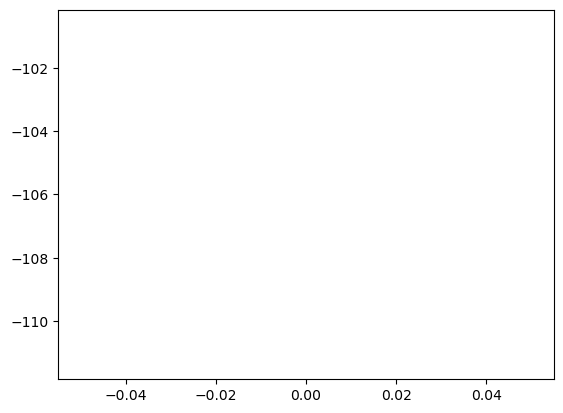

Episode: 1 Total Reward: -107 Epsilon: 0.994009
Episode: 2 Total Reward: -94 Epsilon: 0.991026973
Episode: 3 Total Reward: -102 Epsilon: 0.988053892081
Episode: 4 Total Reward: -84 Epsilon: 0.985089730404757
Episode: 5 Total Reward: -123 Epsilon: 0.9821344612135428
Episode: 6 Total Reward: -104 Epsilon: 0.9791880578299021
Episode: 7 Total Reward: -118 Epsilon: 0.9762504936564125
Episode: 8 Total Reward: -115 Epsilon: 0.9733217421754432
Episode: 9 Total Reward: -96 Epsilon: 0.9704017769489168
Episode: 10 Total Reward: -121 Epsilon: 0.9674905716180701
Episode: 11 Total Reward: -108 Epsilon: 0.9645880999032158
Episode: 12 Total Reward: -116 Epsilon: 0.9616943356035061
Episode: 13 Total Reward: -126 Epsilon: 0.9588092525966956
Episode: 14 Total Reward: -102 Epsilon: 0.9559328248389055
Episode: 15 Total Reward: -90 Epsilon: 0.9530650263643888
Episode: 16 Total Reward: -119 Epsilon: 0.9502058312852957
Episode: 17 Total Reward: -103 Epsilon: 0.9473552137914398
Episode: 18 Total Reward: -111 E

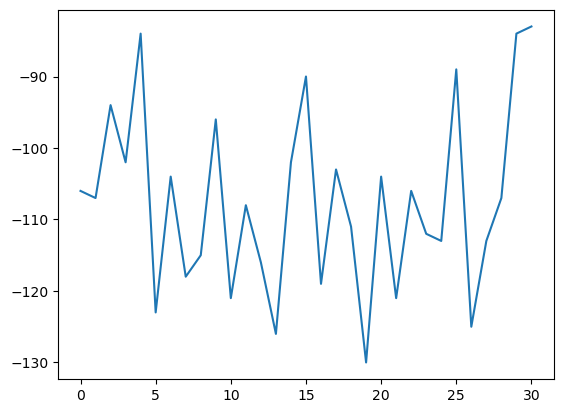

Episode: 31 Total Reward: -94 Epsilon: 0.9083329444789534
Episode: 32 Total Reward: -106 Epsilon: 0.9056079456455165
Episode: 33 Total Reward: -89 Epsilon: 0.90289112180858
Episode: 34 Total Reward: -95 Epsilon: 0.9001824484431542
Episode: 35 Total Reward: -112 Epsilon: 0.8974819010978248
Episode: 36 Total Reward: -114 Epsilon: 0.8947894553945313
Episode: 37 Total Reward: -104 Epsilon: 0.8921050870283477
Episode: 38 Total Reward: -90 Epsilon: 0.8894287717672626
Episode: 39 Total Reward: -87 Epsilon: 0.8867604854519608
Episode: 40 Total Reward: -87 Epsilon: 0.884100203995605
Episode: 41 Total Reward: -99 Epsilon: 0.8814479033836181
Episode: 42 Total Reward: -111 Epsilon: 0.8788035596734672
Episode: 43 Total Reward: -125 Epsilon: 0.8761671489944468
Episode: 44 Total Reward: -99 Epsilon: 0.8735386475474635
Episode: 45 Total Reward: -105 Epsilon: 0.8709180316048211
Episode: 46 Total Reward: -108 Epsilon: 0.8683052775100066
Episode: 47 Total Reward: -105 Epsilon: 0.8657003616774767
Episode:

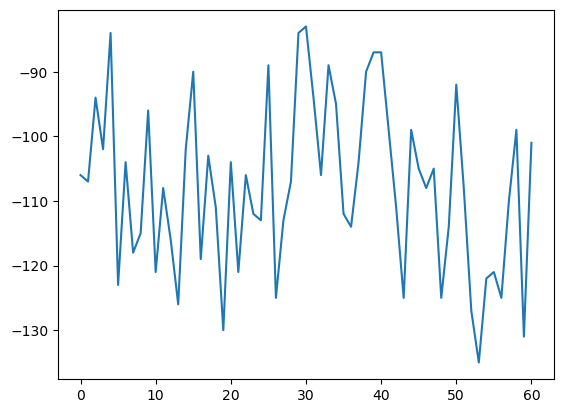

Episode: 61 Total Reward: -112 Epsilon: 0.8300415167526705
Episode: 62 Total Reward: -98 Epsilon: 0.8275513922024125
Episode: 63 Total Reward: -116 Epsilon: 0.8250687380258053
Episode: 64 Total Reward: -112 Epsilon: 0.8225935318117279
Episode: 65 Total Reward: -102 Epsilon: 0.8201257512162927
Episode: 66 Total Reward: -99 Epsilon: 0.8176653739626438
Episode: 67 Total Reward: -123 Epsilon: 0.8152123778407558
Episode: 68 Total Reward: -95 Epsilon: 0.8127667407072335
Episode: 69 Total Reward: -106 Epsilon: 0.8103284404851119
Episode: 70 Total Reward: -95 Epsilon: 0.8078974551636565
Episode: 71 Total Reward: -92 Epsilon: 0.8054737627981655
Episode: 72 Total Reward: -116 Epsilon: 0.803057341509771
Episode: 73 Total Reward: -102 Epsilon: 0.8006481694852418
Episode: 74 Total Reward: -95 Epsilon: 0.798246224976786
Episode: 75 Total Reward: -131 Epsilon: 0.7958514863018556
Episode: 76 Total Reward: -109 Epsilon: 0.79346393184295
Episode: 77 Total Reward: -106 Epsilon: 0.7910835400474212
Episode

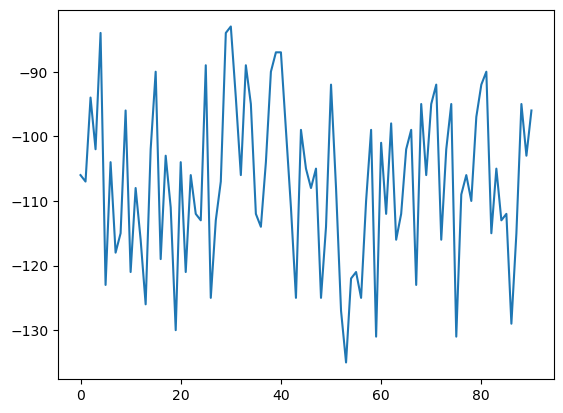

Episode: 91 Total Reward: -129 Epsilon: 0.7584982177744161
Episode: 92 Total Reward: -121 Epsilon: 0.7562227231210928
Episode: 93 Total Reward: -111 Epsilon: 0.7539540549517295
Episode: 94 Total Reward: -105 Epsilon: 0.7516921927868743
Episode: 95 Total Reward: -115 Epsilon: 0.7494371162085136
Episode: 96 Total Reward: -116 Epsilon: 0.747188804859888
Episode: 97 Total Reward: -118 Epsilon: 0.7449472384453084
Episode: 98 Total Reward: -106 Epsilon: 0.7427123967299725
Episode: 99 Total Reward: -79 Epsilon: 0.7404842595397826
Episode: 100 Total Reward: -117 Epsilon: 0.7382628067611632
Episode: 101 Total Reward: -84 Epsilon: 0.7360480183408797
Episode: 102 Total Reward: -98 Epsilon: 0.7338398742858571
Episode: 103 Total Reward: -141 Epsilon: 0.7316383546629995
Episode: 104 Total Reward: -122 Epsilon: 0.7294434395990105
Episode: 105 Total Reward: -128 Epsilon: 0.7272551092802134
Episode: 106 Total Reward: -101 Epsilon: 0.7250733439523728
Episode: 107 Total Reward: -95 Epsilon: 0.72289812392

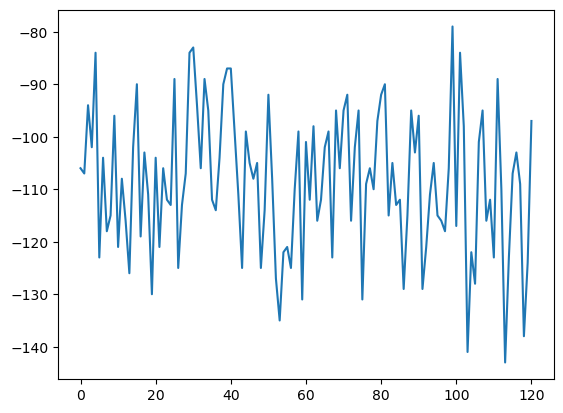

Episode: 121 Total Reward: -112 Epsilon: 0.6931214098997832
Episode: 122 Total Reward: -108 Epsilon: 0.6910420456700839
Episode: 123 Total Reward: -117 Epsilon: 0.6889689195330736
Episode: 124 Total Reward: -92 Epsilon: 0.6869020127744744
Episode: 125 Total Reward: -104 Epsilon: 0.684841306736151
Episode: 126 Total Reward: -80 Epsilon: 0.6827867828159425
Episode: 127 Total Reward: -103 Epsilon: 0.6807384224674947
Episode: 128 Total Reward: -111 Epsilon: 0.6786962072000923
Episode: 129 Total Reward: -100 Epsilon: 0.676660118578492
Episode: 130 Total Reward: -120 Epsilon: 0.6746301382227565
Episode: 131 Total Reward: -101 Epsilon: 0.6726062478080883
Episode: 132 Total Reward: -113 Epsilon: 0.6705884290646641
Episode: 133 Total Reward: -113 Epsilon: 0.66857666377747
Episode: 134 Total Reward: -114 Epsilon: 0.6665709337861376
Episode: 135 Total Reward: -100 Epsilon: 0.6645712209847792
Episode: 136 Total Reward: -143 Epsilon: 0.6625775073218249
Episode: 137 Total Reward: -122 Epsilon: 0.660

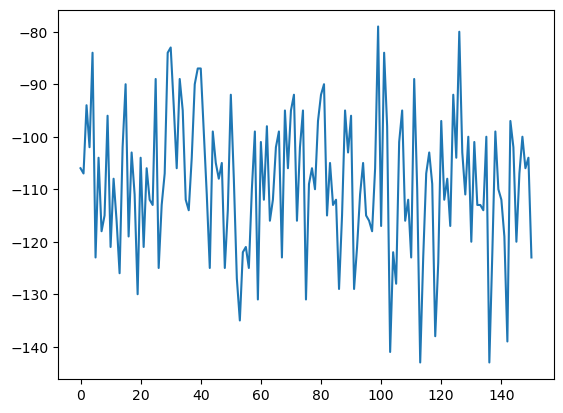

Episode: 151 Total Reward: -109 Epsilon: 0.6333795882488727
Episode: 152 Total Reward: -99 Epsilon: 0.6314794494841262
Episode: 153 Total Reward: -117 Epsilon: 0.6295850111356738
Episode: 154 Total Reward: -99 Epsilon: 0.6276962561022668
Episode: 155 Total Reward: -124 Epsilon: 0.62581316733396
Episode: 156 Total Reward: -98 Epsilon: 0.623935727831958
Episode: 157 Total Reward: -107 Epsilon: 0.6220639206484622
Episode: 158 Total Reward: -103 Epsilon: 0.6201977288865168
Episode: 159 Total Reward: -97 Epsilon: 0.6183371356998573
Episode: 160 Total Reward: -87 Epsilon: 0.6164821242927577
Episode: 161 Total Reward: -115 Epsilon: 0.6146326779198794
Episode: 162 Total Reward: -116 Epsilon: 0.6127887798861198
Episode: 163 Total Reward: -103 Epsilon: 0.6109504135464614
Episode: 164 Total Reward: -94 Epsilon: 0.609117562305822
Episode: 165 Total Reward: -124 Epsilon: 0.6072902096189046
Episode: 166 Total Reward: -119 Epsilon: 0.6054683389900478
Episode: 167 Total Reward: -97 Epsilon: 0.60365193

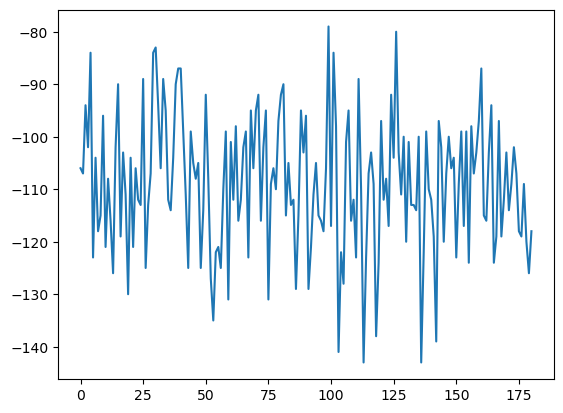

Episode: 181 Total Reward: -111 Epsilon: 0.5787870596412764
Episode: 182 Total Reward: -87 Epsilon: 0.5770506984623526
Episode: 183 Total Reward: -104 Epsilon: 0.5753195463669655
Episode: 184 Total Reward: -95 Epsilon: 0.5735935877278646
Episode: 185 Total Reward: -111 Epsilon: 0.571872806964681
Episode: 186 Total Reward: -108 Epsilon: 0.5701571885437869
Episode: 187 Total Reward: -134 Epsilon: 0.5684467169781556
Episode: 188 Total Reward: -109 Epsilon: 0.5667413768272211
Episode: 189 Total Reward: -112 Epsilon: 0.5650411526967395
Episode: 190 Total Reward: -88 Epsilon: 0.5633460292386493
Episode: 191 Total Reward: -93 Epsilon: 0.5616559911509333
Episode: 192 Total Reward: -111 Epsilon: 0.5599710231774805
Episode: 193 Total Reward: -92 Epsilon: 0.5582911101079481
Episode: 194 Total Reward: -92 Epsilon: 0.5566162367776242
Episode: 195 Total Reward: -96 Epsilon: 0.5549463880672914
Episode: 196 Total Reward: -127 Epsilon: 0.5532815489030894
Episode: 197 Total Reward: -105 Epsilon: 0.55162

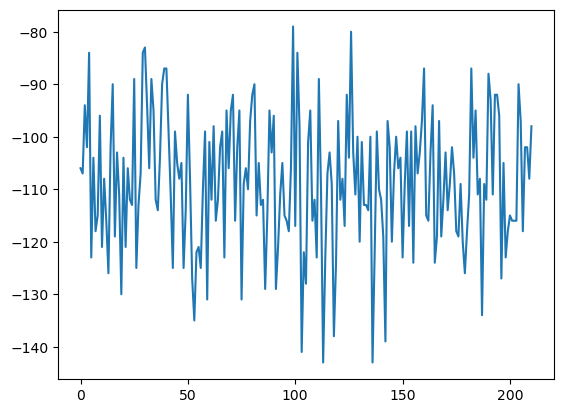

KeyboardInterrupt: 

In [17]:
rewards= []

for episode in range(episodes):
    env.reset()
    oldState, _, done, oldInfo = env.step(0)
    oldState = statePreprocess(oldState)
    heightDiff = np.zeros((1, 10))
    oldTotalReward = 0
    newInfo = {'current_piece': 'none', 'next_piece': 'none'}
    oldData = inputData(heightDiff-heightDiff.min(), oldInfo['current_piece'])
    mergedState = np.zeros_like(oldState)
    while not done:
        if (oldInfo['current_piece'] is None or oldInfo['next_piece'] is None or 
            newInfo['current_piece'] is None or newInfo['next_piece'] is None):
            break
        # Check if we need to force the first action to be '0' for a new piece
        if (piece_type_lookup.get(oldInfo['current_piece'], default_piece_type) != piece_type_lookup.get(newInfo['current_piece'], default_piece_type) or
            piece_type_lookup.get(oldInfo['next_piece'], default_piece_type) != piece_type_lookup.get(newInfo['next_piece'], default_piece_type)):
            action = 0# Force first action to be '0' when a new piece is detected
        elif random.random() < epsilon:
            action = env.action_space.sample() # Choose a random action
        else:
            with torch.no_grad():
                input = oldData # Get the input tensor
                q_values = model(input) # Get the Q-values
                action = random.choice(range(output_dim))#torch.argmax(q_values).item()  # Choose the action with the highest Q-value
        newState, reward, done, newInfo = env.step(action)
        newState = statePreprocess(newState)
        #env.render()
        if ((piece_type_lookup.get(oldInfo['current_piece'], default_piece_type) != 
            piece_type_lookup.get(newInfo['current_piece'], default_piece_type) or
            piece_type_lookup.get(oldInfo['next_piece'], default_piece_type) != 
            piece_type_lookup.get(newInfo['next_piece'], default_piece_type))) and oldInfo['current_piece'] != 'none':
            mergedState = merge_states(oldState, newState, oldInfo)

        heightDiff = calculate_heights(mergedState)
        
        
        newData = inputData(heightDiff-heightDiff.min(), oldInfo['current_piece'])
        newTotalReward = calculate_reward(newInfo['number_of_lines'], mergedState)
        reward = newTotalReward - oldTotalReward
      
        
        replay_memory.append((torch.tensor(newData, dtype=torch.float), torch.tensor(action, dtype=torch.long), torch.tensor(
            reward, dtype=torch.float), torch.tensor(oldData, dtype=torch.float), torch.tensor(done, dtype=torch.float)))
        
        if len(replay_memory) >= batch_size:
            batch = random.sample(replay_memory, batch_size)
            data_batch, action_batch, reward_batch, next_state_batch, done_batch = map(torch.stack, zip(*batch))
            
            q_values = model(data_batch)
            with torch.no_grad():
                next_q_values = model(next_state_batch)
            target_q_values = reward_batch + 0.99 * torch.max(next_q_values, dim=1)[0] * (1 - done_batch)
            loss = loss_fn(q_values[range(batch_size), action_batch], target_q_values)
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
    
        oldInfo = newInfo
        oldState = newState
        oldTotalReward = newTotalReward
        oldData = newData
        
        if done:
            break
    rewards.append(oldTotalReward)
    # Decay epsilon
    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    print('Episode:', episode, 'Total Reward:', oldTotalReward, 'Epsilon:', epsilon)
    #plotting the rewards every 30 episodes
    if episode % 30 == 0:
        plt.plot(rewards)
        plt.show()
        
        
        
        
    
